# Fine Tuning Phi2 LLM with PEFT QLoRA
* Notebook by Adam Lang
* Date: 1/6/2024

# Overview
* In this notebook I will demonstrate how we can fine tune an LLM using PEFT QLoRA technique.

# Workflow
* Data Analysis
* LLM model loading
* PEFT (Parameter Efficient Fine Tuning)
  * QLORA (8-bit)
* Train model
* Model saving
* Model inference

# Phi2 LLM
* We will use the Phi-2 model from hugging face.
  * model card: https://huggingface.co/microsoft/phi-2
  * The model has 2.7B parameters.
* As a review remember there are 2 general types of base models:
  * 1) Open-ended text generation
  * 2) Chat model / Instruction model

* Base models are fine tuned for specific tasks as we see above.

## Fine Tuning Task and Dataset
* We will use a dataset of Amazon Product Reviews on the task of **open ended text generation**.
* We will fine tune the model to generate text data for Amazon product reviews.
    * We will provide a product category and based on the fine tuning tasks, the model will then generate:
        * Product Name
        * Product Description

* Obviously the fine-tuning task is what will allow the model to do this, the base model is not able to do this specifically.

# Install Dependencies
* Make sure these are installed before proceeding.
1. **TRL**
  * This is the most popular package for **Reinforcement Learning from Human Feedback (RLHF)** used to train large language models (LLMs)
  * It is part of the Hugging Face ecosystem and specifically designed to simplify RLHF for fine-tuning language models.
  * * Docs: https://huggingface.co/docs/trl/en/index
  * Excellent blog post: https://medium.com/@jimwang3589/what-is-rlhf-and-how-to-use-it-to-train-an-llm-part-4-1146228b74ef
  * `trl` is a cutting-edge library designed for post-training foundation models using advanced techniques such as:
    * Supervised Fine-Tuning (SFT)
    * Proximal Policy Optimization (PPO)
    * Direct Preference Optimization (DPO)
  


In [1]:
%%capture
!pip install accelerate -U
!pip install bitsandbytes -U
!pip install trl -U
!pip install peft -U
!pip install transformers -U
!pip install datasets -U

# Import Modules

In [44]:
## Standard DS imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

## ML imports
import torch
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM, ## text generation
    #BitsAndBytesConfig, ## don't need 4-bit config for this, we are using 8-bit
    TrainingArguments, ##fine tuning
    Trainer, ## fine tuning
    DataCollatorForLanguageModeling, ## fine-tuning
    pipeline, ## for running inference
)
from datasets import load_dataset, Dataset, DatasetDict ## HF dataset, dataloaders
from peft import LoraConfig, get_peft_model ## peft fine-tuning
from accelerate import Accelerator

# Load Dataset


In [3]:
## load dataset
path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/amazon_product_details.csv'

##load df with only 3 cols
df = pd.read_csv(path,
                 usecols=['category','about_product','product_name'])
## df head
df.head()

,product_name,category,about_product
0,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,High Compatibility : Compatible With iPhone 12...
1,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,"Compatible with all Type C enabled devices, be..."
2,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,【 Fast Charger& Data Sync】-With built-in safet...
3,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,The boAt Deuce USB 300 2 in 1 cable is compati...
4,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,[CHARGE & SYNC FUNCTION]- This cable comes wit...


# Data Wrangling

In [4]:
## lets see what 'category' looks like
df['category'][0]

'Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables'

Summary
* We are going to split this out into just 1 category which is the last category listed.
* Another approach would be to leverage PySpark and split these out into arrays, but we won't do that here.

In [5]:
## split out last category
df['category'] = df['category'].apply(lambda x: x.split('|')[-1])
df['category'].head()

,category
0,USBCables
1,USBCables
2,USBCables
3,USBCables
4,USBCables


In [6]:
## value_counts
df['category'].value_counts()

,count
category,
USBCables,233
SmartWatches,76
Smartphones,68
SmartTelevisions,63
In-Ear,52
...,...
Split-SystemAirConditioners,1
SmallApplianceParts&Accessories,1
StovetopEspressoPots,1


In [7]:
## preprocessing -- split out into 2 groups
products = df[['category','product_name']]
description = df[['category','about_product']]


## Create 2 new df's
products = products.rename(columns={'product_name': 'text'})
description = description.rename(columns={'about_product': 'text'})


## create new column --> task type for each new df
products['task_type'] = 'Product Name'
description['task_type'] = 'Product Description'

In [8]:
## products df
products.head()

,category,text,task_type
0,USBCables,Wayona Nylon Braided USB to Lightning Fast Cha...,Product Name
1,USBCables,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Product Name
2,USBCables,Sounce Fast Phone Charging Cable & Data Sync U...,Product Name
3,USBCables,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Product Name
4,USBCables,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Product Name


In [9]:
## description df
description.head()

,category,text,task_type
0,USBCables,High Compatibility : Compatible With iPhone 12...,Product Description
1,USBCables,"Compatible with all Type C enabled devices, be...",Product Description
2,USBCables,【 Fast Charger& Data Sync】-With built-in safet...,Product Description
3,USBCables,The boAt Deuce USB 300 2 in 1 cable is compati...,Product Description
4,USBCables,[CHARGE & SYNC FUNCTION]- This cable comes wit...,Product Description


In [10]:
## concat the 2 dfs into 1 df
df = pd.concat([products, description], ignore_index=True)
df.head()

,category,text,task_type
0,USBCables,Wayona Nylon Braided USB to Lightning Fast Cha...,Product Name
1,USBCables,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Product Name
2,USBCables,Sounce Fast Phone Charging Cable & Data Sync U...,Product Name
3,USBCables,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Product Name
4,USBCables,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Product Name


In [11]:
## value counts of task_type
df['task_type'].value_counts()

,count
task_type,
Product Name,1465
Product Description,1465


Summary
* We can see there are equal counts of `Product Name` and `Product Description`

# Create Dataset and Train/Test split
* We need to create a dataset from our pandas df in order to fine tune the model using a huggingface model.
* First we create a HF model then we create a DatasetDict which is the format for a data loader for huggingface.

In [12]:
## dataset creation
def create_data(dataframe):
  ## convert from df to hf dataset
  dataset = Dataset.from_pandas(df)

  ## shuffle dataset for training
  dataset = dataset.shuffle(seed=42)

  # create train_test_split
  dataset = dataset.train_test_split(test_size=0.1)

  return dataset

In [13]:
## apply to df
final_data = create_data(df)
final_data

DatasetDict({
    train: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 2637
    })
    test: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 293
    })
})

In [14]:
## lets see the 'test' set
final_data['test'][3]

{'category': 'JuicerMixerGrinders',
 'text': "Performance with Style:India's favourite Mixer-Grinder-Blender, Nutri - blend, is the perfect combination of superior performance and superb styling that adds beauty to your kitchen, Nutri - blend CKM (Complete Kitchen Machine) comes with extra attachments – a Big Jar for yummy shakes, Juicer attachment and an exciting Chopper, offering an all-in-one solution that functions as a mixer, grinder, blender, juicer and chopper – all in one. Also get the food processor attachment|Powerful Motor: The compact yet powerful machine grinds the toughest of chutneys and masalas, and ensures nutrition extraction from all fruits and veggies thanks to its incredibly high speed of 22,000 RPM, which is almost twice that of normal mixer-grinders|Hands-Free operation: Best thing is you don’t need to keep your hand on the lid during operation, for the fear of it flying off. This is because Nutri - blend has the unique inverted design that has the lid screwed sa

# Exploratory Data Analysis - EDA
* The main purpose of this is to analyze the dataset token counts so we know how to handle this when fine tuning the Phi-2 model.

In [15]:
## 1.5 times total num of words per token
products['text_tokens'] = products['text'].apply(lambda x: len(x.split())*1.5)
description['text_tokens'] = description['text'].apply(lambda x: len(x.split())*1.5)



In [16]:
## products
products.head()

,category,text,task_type,text_tokens
0,USBCables,Wayona Nylon Braided USB to Lightning Fast Cha...,Product Name,48.0
1,USBCables,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Product Name,46.5
2,USBCables,Sounce Fast Phone Charging Cable & Data Sync U...,Product Name,40.5
3,USBCables,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Product Name,48.0
4,USBCables,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Product Name,30.0


### Histogram for Products and Description Text Tokens

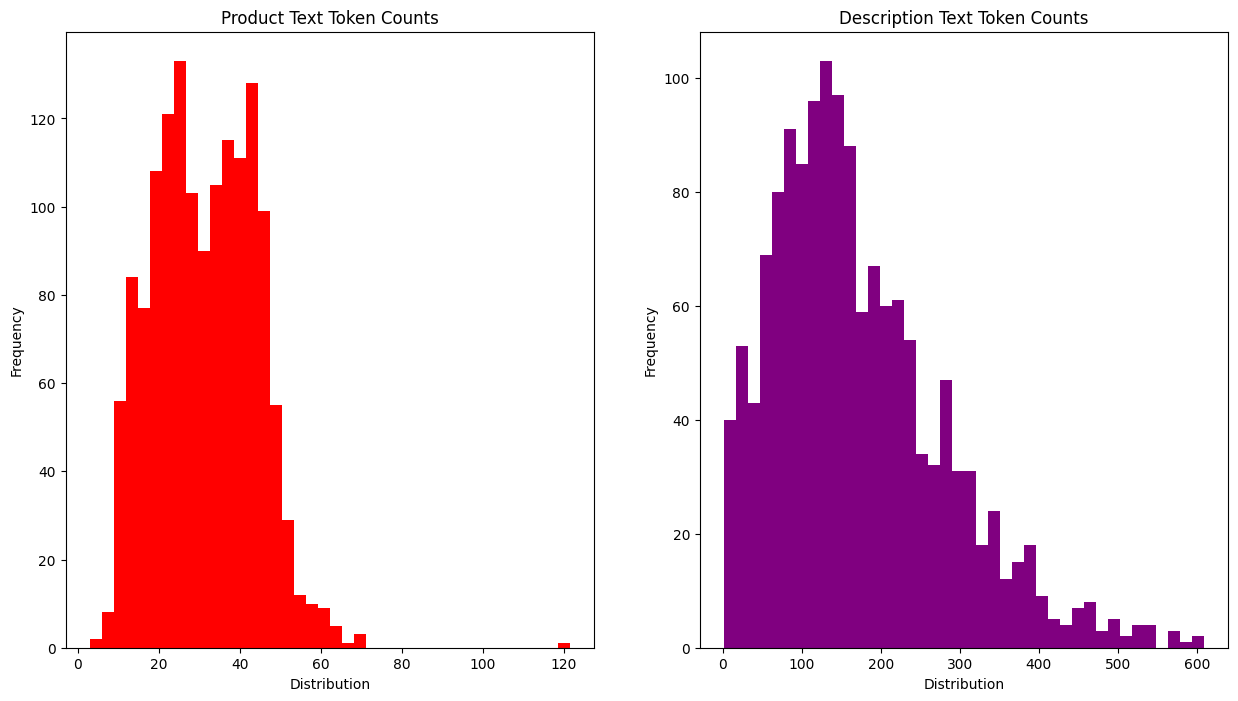

In [17]:
## histograms of token counts
fig, ax = plt.subplots(1,2, figsize=(15,8))

## plot product text tokens
ax[0].hist(products['text_tokens'],bins=40,color='red')
ax[0].set_title('Product Text Token Counts')
ax[0].set_xlabel('Distribution')
ax[0].set_ylabel('Frequency')

## plot description text tokens
ax[1].hist(description['text_tokens'],bins=40,color='purple')
ax[1].set_title('Description Text Token Counts')
ax[1].set_xlabel('Distribution')
ax[1].set_ylabel('Frequency')

plt.show();

### Boxplots for Products and Descriptions for Text Tokens

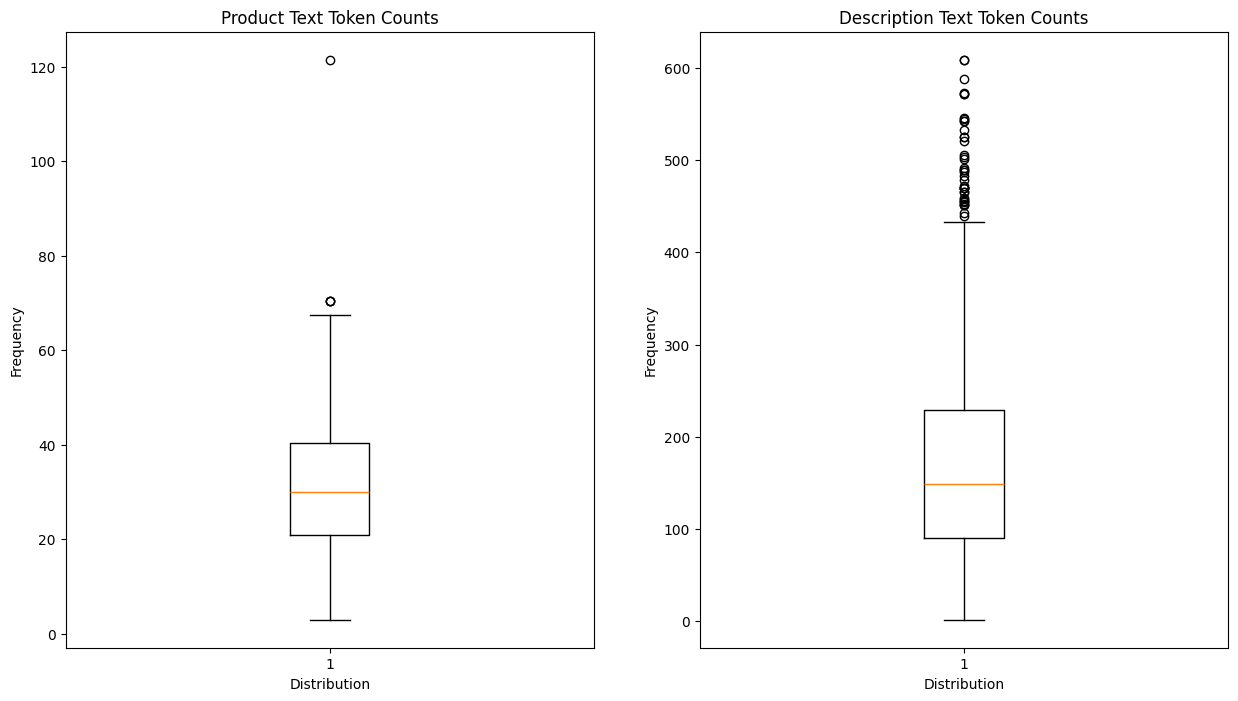

In [18]:
## boxplots of token counts
fig, ax = plt.subplots(1,2, figsize=(15,8))

## plot product text tokens -- boxplot
ax[0].boxplot(products['text_tokens'])
ax[0].set_title('Product Text Token Counts')
ax[0].set_xlabel('Distribution')
ax[0].set_ylabel('Frequency')

## plot description text tokens -- boxplot
ax[1].boxplot(description['text_tokens'])
ax[1].set_title('Description Text Token Counts')
ax[1].set_xlabel('Distribution')
ax[1].set_ylabel('Frequency')

plt.show();

Summary
* Through this analysis we can see that for the Products most of the token counts are between 20 and 40 with the median at about 25, and the max outlier is at 120.
* For the Description token counts it is evident most of the tokens are between 100 and 250 with the median around 150 and the 3rd quartile extending out to just above 400.
  * This is a good indication that we may want to set our token count close to 400.
* The context window of Phi-2 is around 2048 tokens.

# Load Base Model and Data Formatting
* Here we will load the base model and tokenize the text data prior to fine tuning.
* The task we are fine tuning for is for the base model to be able to take in a Task Category and generate a product name and description.

```
Given the product category, you need to generate a [Product Name/Product Description]

### Category: [USB Cable]

### [Product Name/Product Description] : [Product name or description]
```

## Formatting

In [19]:
## Prompt formatting function
def format_func(example):
  """Function that given input prompt text generates product name/description"""
  text = f"""
            Given the product category, you need to generate a '{example['task_type']}'.
            ### Category: {example['category']}\n ### {example['task_type']}: {example['text']}

          """

  return text

In [20]:
## testing function
print(format_func(final_data['train'][1]))


            Given the product category, you need to generate a 'Product Description'.
            ### Category: Mice
 ### Product Description: Modern, slim and beautiful Pebble shape Logitech Pebble has stand-out simplicity with a design that is nice to hold, feels great in your hand and is easy to carry around. Sensor resolution: 1000 dpi;Silent clicks and ultra-quiet scrolling. Enjoy the same click feel with over 90% noise reduction on the click sound|Dual connectivity. Connect the way you like via Bluetooth wireless technology or via the included tiny USB receiver;Long battery life. Logitech Pebble stays powered for up to 18 months on a single AA battery|High-precision optical tracking. Logitech Pebble tracks fast and accurately where you want to use it;Modern, slim and beautiful Pebble shape Logitech Pebble has stand-out simplicity with a design that is nice to hold, feels great in your hand and is easy to carry around;Note : In case of Wireless mouse, the USB receiver will be pro

Summary:
* Given this formatting function we can use this for any domain that we want to fine tune the model on to generate text given an input.

## Load Base Model
* The goal is to fine tune a base model. Phi-3 does not have a base model so we will use Phi-2 which is a base model.
* Loading a Model in 8-bit Quantization
  * This can be achieved by using the `load_in_8bit=True` argument when calling `.from_pretrained.`
      * **This reduces the memory footprint by approximately half.**
  * If we loaded the model in `load_in_4bit=True` we would reduce memory usage by four fold.



In [21]:
## set model ckpt from HF
base_model_ckpt = 'microsoft/phi-2'

## load model
llm = AutoModelForCausalLM.from_pretrained(base_model_ckpt,
                                           trust_remote_code=True,
                                           torch_dtype=torch.float16,
                                           load_in_8bit=True)



config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## Tokenization
* Here we will use left padding because we are using an autoregressive generative model which "looks left and predicts right".
* We want the model to "complete the sentence" rather than using masked language modeling.
* If we did not use padding on the left, then the model would continue generating text to an infinite number.

```
As an example:
## i like apple
## because i am from mars
## i like apple [pad][pad] because i am from mars --> right padding
## [pad][pad] i like apple because i am from mars --> left padding
```

In [22]:
## setup tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    base_model_ckpt,
    padding_size='left',
    add_eos_token=True, ## add end of sequence tokens
    add_bos_token=True, ## add beginning sequence token
    use_fast=False, ## fast tokenizer not allowed for Phi-2
)

## assign pad_token == eos_token
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

### Details about Tokenization function
* Most of the code below is self explanatory. However, it is important to understand this line:
```
result['labels'] = result['input_ids'].copy()
```

* Purpose
  * This line creates a 'labels' key within the result dictionary and assigns it a copy of the 'input_ids'.
* Reasoning
  * In self-supervised learning, the model is trained to **predict the next token in the sequence**.
  * By setting the 'labels' equal to the 'input_ids', the model is essentially trained to **predict the input itself, which can be a useful pre-training strategy for language models.**


In [23]:
## parameters
max_length = 400 ## based on token counts

## tokenize function
def tokenize(prompt):
  """Function tokenizes input text"""
  result = tokenizer(
      format_func(prompt), ## format the prompt
      truncation=True,
      max_length=max_length,
      padding="max_length" ## pad to max_length
  )
  ## self supervised text generation
  result['labels'] = result['input_ids'].copy()

  return result

In [24]:
## testing the tokenization function
print(tokenize(final_data['train'][0]))

{'input_ids': [50256, 198, 50276, 15056, 262, 1720, 6536, 11, 345, 761, 284, 7716, 257, 705, 15667, 12489, 4458, 198, 50276, 21017, 21743, 25, 4333, 33, 2283, 198, 44386, 8721, 12489, 25, 939, 405, 28142, 19730, 1505, 12280, 647, 6555, 91, 1507, 54, 12549, 14797, 278, 91, 14824, 1154, 2493, 5072, 91, 36248, 5128, 2493, 357, 13031, 12, 27155, 14, 27155, 12, 34, 11, 14797, 278, 3862, 1058, 718, 13, 24, 2250, 91, 13434, 28682, 91, 28809, 1105, 34398, 11594, 4800, 91, 25610, 1176, 4542, 91, 21, 1933, 5928, 18215, 628, 50278, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 5025

Tokenize entire dataset

In [25]:
## tokenize entire dataset
final_data = final_data.map(tokenize)

Map:   0%|          | 0/2637 [00:00<?, ? examples/s]

Map:   0%|          | 0/293 [00:00<?, ? examples/s]

# Testing Phi-2 Base Model "Out of the Box"
* Let's see how this model works WITHOUT fine tuning and why fine-tuning for specific tasks is an important tool to have.
* Lets try a zero-shot out of the box prompt.

In [29]:
## setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
## test with eval_prompt --> Zero shot prompt
eval_prompt = """
Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
 ### Product Description:
"""

In [33]:
## 1. Tokenize data
model_input = tokenizer(
    eval_prompt,
    truncation=True,
    max_length=max_length,
    padding="max_length",
    return_tensors='pt',
).to(device) ## move model_input to device


In [34]:
## 2. Generate outputs

llm.eval()
## no gradients needed
with torch.no_grad():
  output = llm.generate(**model_input,
                        max_new_tokens=256,
                        repetition_penalty=1.15)



## 3. Decode outputs
  result = tokenizer.decode(output[0],
                            skip_special_tokens=True)


  print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
 ### Product Description: 



Rules of the puzzle:
1. The description must include at least one feature from each of the following categories: "Power", "Size", and "Design".
2. Each feature should be described in detail using direct quotes or paraphrased sentences.
3. Use the property of transitivity (if A is related to B, and B is related to C, then A is also related to C) when describing features that are indirectly linked through other features.
4. Use inductive logic to infer additional details about the product based on the given information.
5. Use deductive reasoning to eliminate irrelevant or contradictory statements.
6. Make sure your final product description adheres to all rules and accurately represents the product.

Question: What would be an accurate and detailed 'Product Description' for this battery charger?


Start by identifying the key features mentioned in the pa

Summary
* Its clear that using the model "out of the box" it does not generate text as we instructed it to do based on our zero-shot test above.
* Hence why we need to fine tune on the task we are specifically interested in!

# QLoRA Config
* Now we need to configure 8-bit QLoRA Configuration for Fine tuning.
* Note about 8-bit config:
  * We don't need to use bitsandbytes here because that is 4-bit config and we have chosen to use 8-bit config.

* Remember, that quantization reduces the precision of the numbers (weights) in our model.
  * Instead of using 32 bits to represent a number, we use 8 bits or even 4 bits.
  * **This dramatically cuts down the memory usage.**
* Think of this as "Elephant sizes" as described by this awesome blog post: https://medium.com/@shikharstruck/shrinking-elephants-a-funny-guide-to-4-bit-and-8-bit-quantization-for-llms-with-lora-ddf9f1a62070


1. 32-bit Float (Full-Size Elephant)
  * High precision
  * large size

2. 8-bit Quantization (Smaller Elephant)
  * Reduced precision
  * smaller size

3. 4-bit Quantization (Tiny Elephant)
  * Even less precision
  * tiniest size!



## LoRA configs
The LoRA configuration is set up using the `LoraConfig` class (source: https://medium.com/@amodwrites/a-definitive-guide-to-qlora-fine-tuning-falcon-7b-with-peft-78f500a1f337)

The parameters in this configuration include:

* `r`
  * The rank of the update matrices.
  * Lower rank results in smaller update matrices with fewer trainable parameters.

* `lora_alpha`
  * LoRA scaling factor

* `target_modules`
  * The modules (for example, attention blocks) to apply the LoRA update matrices.

* `lora_dropout`
  * Dropout probability of the LoRA layers

* `bias`
  * Specifies if the bias parameters should be trained. Can be :
    * `none`
    * `all` or
    * `lora_only`


In [38]:
## setup target configs
## query, key, value, fully connected layers 1 and 2
target_modules = ["Wqkv", "fc1","fc2"]

## using 8-bit so we dont need bitsandbytes which is 4-bit config
config = LoraConfig(
    r=32, ## rank matrix
    lora_alpha=64,
    target_modules=target_modules, #layers to target
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM", #text generation

)

## transforms from FULL model to PEFT model
peft_model = get_peft_model(llm, config)

In [39]:
peft_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiSdpaAttention(
              (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (rotary_emb): PhiRotaryEmbedding()
            )
            (mlp): PhiMLP(
              (activation_fn): NewGELUActivation()
              (fc1): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
                (lora_dropout): ModuleDict(
                  (default

Summary
* We have the base model and the peft model above.

In [40]:
## trainable parameters
def print_train_params(model):
  """
  Function prints the number of trainable params in the LLM model.
  """
  ## store count of params
  trainable_params=0
  all_param=0
  ## iterates through all `named_parameters()` in the model
  for _, param in model.named_parameters():
    all_param += param.numel()
    ## if model requires updated weights/gradients --> these are trainable params
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
  )

In [41]:
## printing trainable params
print_train_params(peft_model)

trainable params: 26214400 || all params: 2805898240 || trainable%: 0.9342605382581515


Summary
* We can see there are 0.93% of the total parameters that are trainable, or less than 1% of the total.
* With QLoRA we reduce the memory footprint significantly.

# Model Training
* Here we need:

1. Trainer
2. TrainingArguments
3. DataCollator

In [43]:
## init accelerator
accelerator = Accelerator(gradient_accumulation_steps=1) ## every step updates model weights via backprop

## model setup
model = accelerator.prepare_model(peft_model)

In [45]:
## setting up the training

project = "phi2-finetune" #directory
run_name = "train-dir"
output_dir = "./" + run_name

## training args
args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    max_steps=500,
    learning_rate=2.5e-5,     ## small lr for finetuning!
    optim="paged_adamw_8bit", # optimizer
    logging_steps=25,        ## when to start reporting loss
    logging_dir="./logs",    ## directory for storing logs
    save_strategy="steps",   ## save model checkpoint every logging step
    save_steps=25,           ## save checkpoints every 50 steps
    eval_strategy="steps",   ## eval model every logging step
    eval_steps=25,           ## eval and save checkpoints every 50 steps
    do_eval=True,
)

## setup Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=final_data['train'],
    eval_dataset=final_data['test'],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False), # do not need masking --> predicting next word!
)

model.config.use_cache=False ## silence warnings, re-enable for inference

## train model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
25,3.751600,3.471248
50,3.481000,3.254253
75,3.199000,3.062170
100,3.109800,2.909566
125,2.873900,2.838521
150,2.801100,2.753569
175,2.841300,2.715132
200,2.820100,2.683419
225,2.739500,2.672156
250,2.787100,2.663220


TrainOutput(global_step=500, training_loss=2.8660071716308595, metrics={'train_runtime': 1551.2197, 'train_samples_per_second': 0.645, 'train_steps_per_second': 0.322, 'total_flos': 6419582976000000.0, 'train_loss': 2.8660071716308595, 'epoch': 0.37907505686125853})

# Inference with Trained Model | Load PEFT Model
* By default the PEFT library will only save the QLoRA adapters so we need to first load the base model from the huggingface hub.
* This is the process:
1. Load base model from HF
2. Merge PEFT model with checkpoints

In [48]:
import torch ## just in case you want to start here

## 1. load base model --> Phi-2
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_ckpt,
    trust_remote_code=True, #download automatically
    load_in_8bit=True,
    torch_dtype=torch.float16,
)


## can create separate tokenizer
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_ckpt,
    add_bos_token=True, ## begin sentence token
    trust_remote_code=True,
    use_fast=False, ## don't use fast tokenizer
)
## set `pad_token` == `eos_token`
eval_tokenizer.pad_token = eval_tokenizer.eos_token

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [55]:
from peft import PeftModel

In [57]:
#from peft import peftModel ## convert base model to peft model

## merge base model with fine-tuned PEFT model
ft_model = PeftModel.from_pretrained(base_model,
                                     '/content/train-dir/checkpoint-500') ## final checkpoint here

## Inference with Fine-tuned model

In [59]:
## using zero-shot eval_prompt from above
eval_prompt = """
Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
 ### Product Description:
"""

## 1. Tokenization
model_input = eval_tokenizer(eval_prompt, return_tensors='pt').to(device)


## 2. Generate outputs with `ft_model` -- fine tuned model
ft_model.eval()
with torch.no_grad():
  output = ft_model.generate(**model_input,
                        max_new_tokens=256,
                        repetition_penalty=1.15)



## 3. Decode outputs
  result = tokenizer.decode(output[0],
                            skip_special_tokens=True)


  print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Given the product category, you need to generate a 'Product Description'.
### Category: BatteryChargers
 ### Product Description: 
#### Name: PowerMax USB Charger for iPhone/iPad/Android (Black)
#### Features:
##### 1. Fast charging with up to 10W fast charger and 2A power adapter
##### 2. Supports multiple devices simultaneously via micro-USB port
##### 3. Compact design fits in your pocket or bag
##### 4. Suitable for both indoor and outdoor use due to its IP68 rating

            ## Category: Accessories
 ### Product Description: 
#### Name: PowerMax USB Charger for iPhone/iPad/Android (White)
#### Features:
##### 1. Fast charging with up to 10W fast charger and 2A power adapter
##### 2. Supports multiple devices simultaneously via micro-USB port
##### 3. Compact design fits in your pocket or bag
##### 4. Suitable for both indoor and outdoor use due to its IP68 rating

            ## Category: Smartphones
 ### Product Description: 
#### Name: PowerMax USB Charger for iPhone/iPad/An

# Summary
* We were able to fine-tune the Phi-2 LLM base model on a specific task to generate product name and product descriptions given a product category.
* We can also see that the generative AI output is much improved once fine-tuned compared to the base model.

# Saving the Model
* If we wanted to save the model in a zip file we can run this code.

In [ ]:
## zip in recursive format -- uncomment to save
# !zip -r /content/phi2_qlora_adapter.zip/content/phi2-journal-finetune/checkpoint-500

# Appendix

* These are the outputs from Weights & Biases Monitoring of the training/fine-tuning.

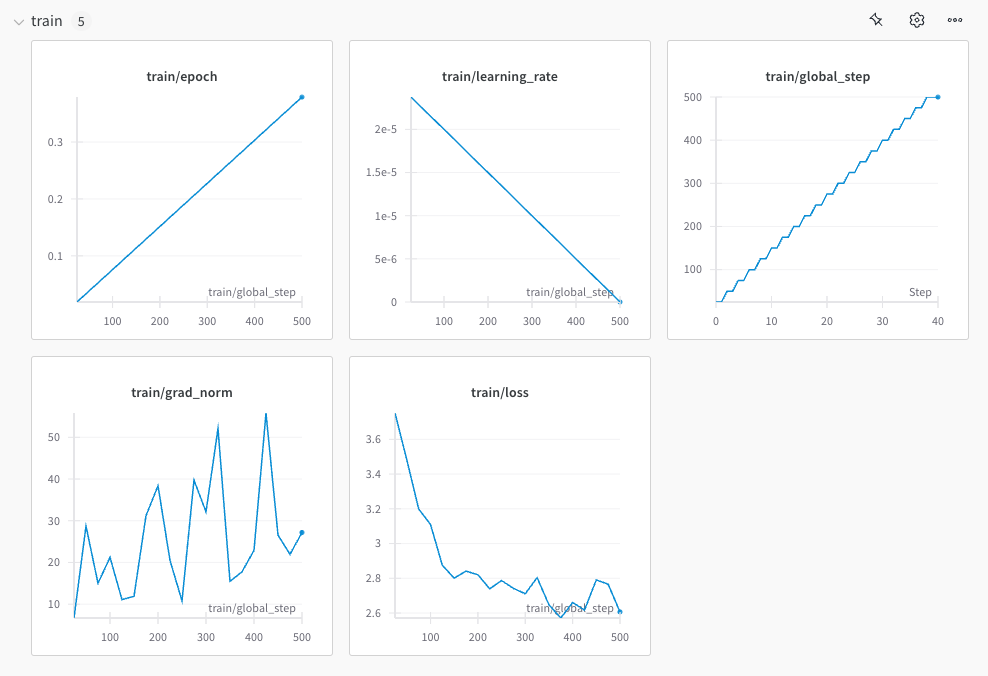

* These are the outputs from the Weights & Biases Monitoring of the eval:
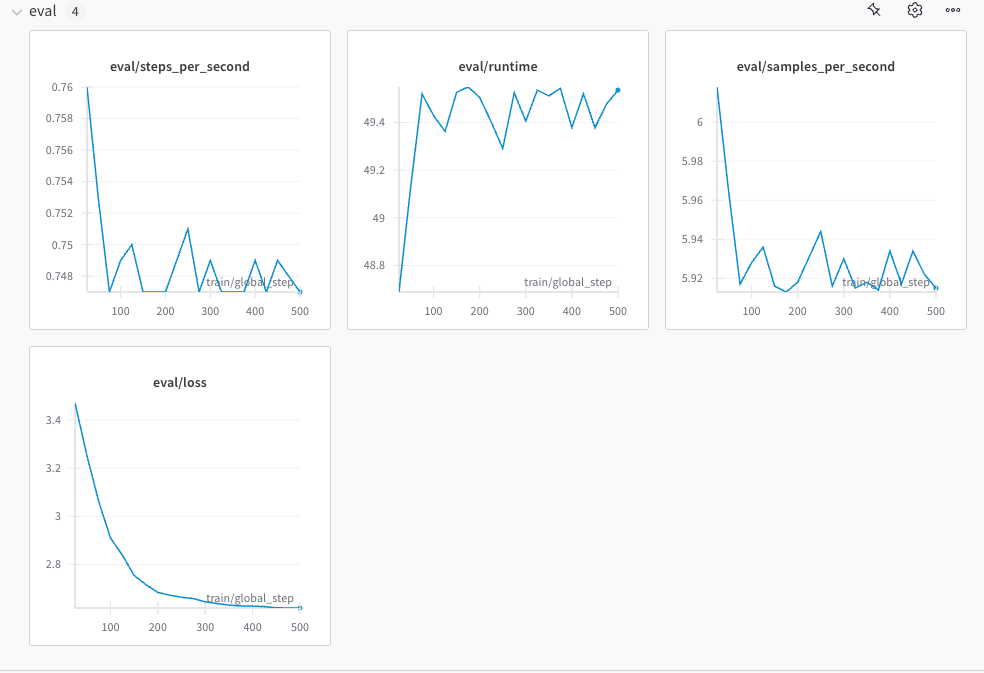